In [1]:
import pandas as pd
import torch
import os
import torch.nn as nn

# download emotions.csv from 
# https://www.kaggle.com/datasets/birdy654/eeg-brainwave-dataset-feeling-emotions
# and load it

data=pd.read_csv(r"C:\Users\argdi\Desktop\gitProblems\emotions.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

import numpy as np
import torch
y = data['label'] #targets (emotions)
dictLabel = {'POSITIVE': 0, 'NEGATIVE':1, 'NEUTRAL': 2} 
yNum = data['label'].map(dictLabel) #convert target labels to numeric values
x = data.drop(columns = 'label') #features

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#scale data with standard scaler
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x))


In [2]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,2538,2539,2540,2541,2542,2543,2544,2545,2546,2547
0,-0.696086,0.354912,-1.217244,0.118199,0.151545,0.058107,0.042167,-0.235032,0.118970,0.161980,...,0.326344,-0.383307,0.644530,0.644530,-0.383307,-0.740515,0.910153,-1.060843,-1.060843,0.910153
1,0.886267,0.657191,0.664209,0.722797,-0.095212,0.362931,0.191335,0.037871,0.223051,-0.259024,...,0.513279,-0.603560,0.269086,0.269086,-0.603560,0.672424,-0.455506,0.164015,0.164015,-0.455506
2,-0.416000,0.257751,-1.508190,0.183401,-0.031760,4.443013,0.388815,1.320424,5.284193,0.102818,...,-1.715175,1.680389,-1.614376,-1.614376,1.680389,-0.925585,0.915075,-0.929340,-0.929340,0.915075
3,-0.023357,0.495256,-0.184384,0.367151,0.010541,-0.033897,-0.039529,0.125117,0.133083,-0.108477,...,-0.537182,0.913268,-1.703555,-1.703555,0.913268,0.494472,-0.529197,0.550352,0.550352,-0.529197
4,0.853547,0.462869,0.728218,0.811708,0.024642,1.934333,-0.686747,0.040514,2.432265,0.287172,...,0.459582,-0.437429,0.803268,0.803268,-0.437429,0.448205,-0.554794,0.685331,0.685331,-0.554794


In [3]:
#convert to torch tensors
x = torch.tensor(x.values, dtype=torch.float32)
y = torch.tensor(yNum.values)

x_train, x_val, y_train, y_val = train_test_split(x, y, train_size = 0.8)
#K-Nearest Neighbors (KNN) Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Create a KNN classifier with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)  

# Train the classifier
knn.fit(x_train, y_train)

# Predict on the validation set
y_pred = knn.predict(x_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=dictLabel.keys())

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9484777517564403
Classification Report:
              precision    recall  f1-score   support

    POSITIVE       0.97      0.88      0.92       147
    NEGATIVE       0.92      0.98      0.95       153
     NEUTRAL       0.96      0.99      0.98       127

    accuracy                           0.95       427
   macro avg       0.95      0.95      0.95       427
weighted avg       0.95      0.95      0.95       427



In [4]:
#below we train the model using the SVM classifier
from sklearn.svm import SVC

# Create an SVM classifier with a linear kernel and C=1.0
svm = SVC(kernel='linear', C=1.0, random_state=1)

#train the classifier
svm.fit(x_train, y_train)

#predict on the validation set
y_pred = svm.predict(x_val)

#evaluate the model
accuracy = svm.score(x_val, y_val)
print(f'Accuracy: {accuracy}')
clr = classification_report(y_val, y_pred, target_names=dictLabel.keys())
print("Classification Report:\n----------------------\n", clr)

Accuracy: 0.9625292740046838
Classification Report:
----------------------
               precision    recall  f1-score   support

    POSITIVE       0.96      0.93      0.94       147
    NEGATIVE       0.96      0.97      0.96       153
     NEUTRAL       0.97      0.99      0.98       127

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427



In [5]:
#we pass the data to gpu
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

#create dataloaders
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)


batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)  
valid_dl = DataLoader(val_ds, batch_size, shuffle=False)  

#Neural network model
class myModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        #linear
        self.fc1 = nn.Linear(2548, 1024)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(1024, 256)
        self.relu2 = nn.ReLU()
        self.drop = nn.Dropout(p = 0.5)
        self.fc3 = nn.Linear(256, 3)
        
        # Create a module list for easy access
        l = [self.fc1, self.relu1, self.fc2, self.relu2, self.drop, self.fc3]
        self.module_list = nn.ModuleList(l)
    
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x        

In [6]:
#create an instance of the model and move it to gpu
model = myModel().to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
# Lists to store the loss and accuracy history for training and validation
loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
# Training loop
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
        
        # Forward pass
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Update loss and accuracy
        loss_hist_train[epoch] += loss.item()*batch_size
        is_correct = (torch.argmax(pred, dim=1)== y_batch).float()
        accuracy_hist_train[epoch] += float(is_correct.sum().item())
    # Compute average loss and accuracy for the epoch
    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()
        
    with torch.no_grad():
        for x_batch, y_batch in valid_dl:
            # Forward pass
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            
            # Update loss and accuracy
            loss_hist_valid[epoch] += loss.item()*batch_size
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_valid[epoch] += float(is_correct.sum().item())
    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
    
    print(f'Epoch {epoch+1} accuracy: '
          f'{accuracy_hist_train[epoch]:.4f} val_accuracy: ' 
          f'{accuracy_hist_valid[epoch]:.4f} loss:'
          f'{loss_hist_train[epoch]:.4f} val_loss:'
          f'{loss_hist_valid[epoch]:.4f}')

Epoch 1 accuracy: 0.8053 val_accuracy: 0.9321 loss:0.5222 val_loss:0.2528
Epoch 2 accuracy: 0.9196 val_accuracy: 0.9157 loss:0.2199 val_loss:0.2976
Epoch 3 accuracy: 0.9531 val_accuracy: 0.9274 loss:0.1374 val_loss:0.2088
Epoch 4 accuracy: 0.9648 val_accuracy: 0.9415 loss:0.1135 val_loss:0.2099
Epoch 5 accuracy: 0.9830 val_accuracy: 0.9438 loss:0.0561 val_loss:0.2457
Epoch 6 accuracy: 0.9889 val_accuracy: 0.9508 loss:0.0367 val_loss:0.2406
Epoch 7 accuracy: 0.9894 val_accuracy: 0.9625 loss:0.0311 val_loss:0.1705
Epoch 8 accuracy: 0.9953 val_accuracy: 0.9649 loss:0.0203 val_loss:0.1539
Epoch 9 accuracy: 0.9924 val_accuracy: 0.9578 loss:0.0283 val_loss:0.2084
Epoch 10 accuracy: 0.9959 val_accuracy: 0.9649 loss:0.0119 val_loss:0.2333


In [7]:
import torch.nn.functional as F

# Classification report for the neural network model
model.to(torch.device('cpu'))
x_val = x_val.to(torch.device('cpu'))
y_val = y_val.to(torch.device('cpu'))
pred = model(x_val)

predicted_labels = torch.argmax(F.softmax(pred, dim=1), dim=1)
report = classification_report(y_val, predicted_labels)
print("Neural network: ")
print(report)

Neural network: 
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       147
           1       0.94      1.00      0.97       153
           2       0.97      0.99      0.98       127

    accuracy                           0.96       427
   macro avg       0.97      0.97      0.97       427
weighted avg       0.97      0.96      0.96       427



Text(0.5, 1.0, 'Confusion Matrix')

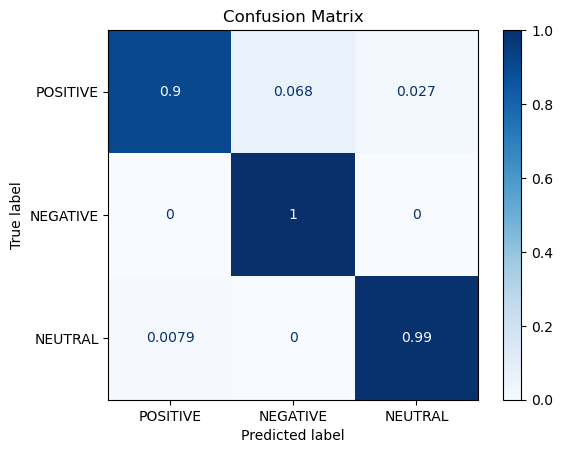

In [8]:
# Confusion matrix for the neural network model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, predicted_labels)
cmNorm = cm.astype(float)/cm.sum(axis=1)[:, np.newaxis]
cmNorm

disp = ConfusionMatrixDisplay(confusion_matrix=cmNorm, display_labels=dictLabel.keys())
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix')

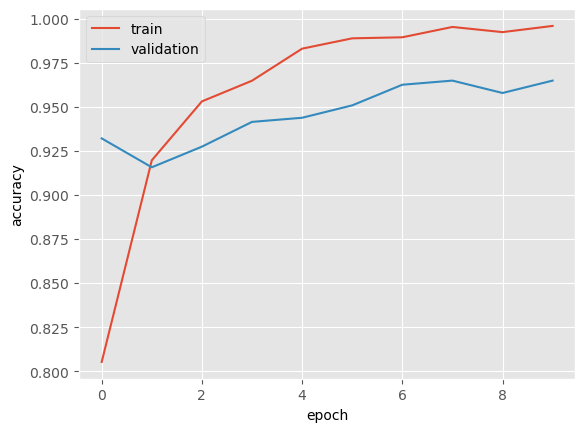

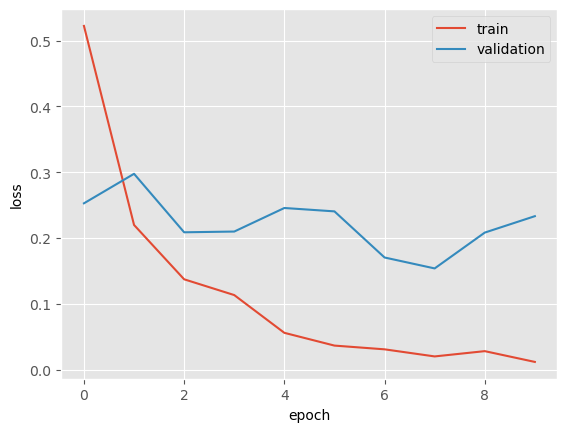

In [9]:
#plot training, validation loss and accuracy
plt.style.use('ggplot')
plt.figure(1)
plt.clf()
plt.plot(accuracy_hist_train, label='train')
plt.plot(accuracy_hist_valid, label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure(2)
plt.clf()
plt.plot(loss_hist_train, label = 'train')
plt.plot(loss_hist_valid, label = 'validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()